In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def SIR(S0,I0,R0, beta, gamma, mu_birth, mu_death, t_max, stepsize, n_target=None):
    T = np.arange(0,t_max+stepsize,stepsize)
    S = np.zeros(len(T))
    I = np.zeros(len(T))
    R = np.zeros(len(T))
    # N = S0+I0+R0 # This can't be constant if we are including births and deaths in the model
    
    for idx, t in enumerate(T):
        if idx==0:
            S[idx] = S0
            I[idx] = I0
            R[idx] = R0
        else:
            N = S[idx-1] + I[idx-1] + R[idx-1]
            if N <= 0:
                S[idx], I[idx], R[idx] = 0.0, 0.0, 0.0
                continue

            # The math here can be thought of as X_new = X_old + dX_dt * dt
            dS_dt = -beta * S[idx-1] * I[idx-1] / N + mu_birth * N - mu_death * S[idx-1]
            dI_dt = beta * S[idx-1] * I[idx-1] / N - gamma * I[idx-1] - mu_death * I[idx-1]
            dR_dt = gamma * I[idx-1] - mu_death * R[idx-1]
            
            S[idx] = max(S[idx-1] + dS_dt * stepsize, 0.0)
            I[idx] = max(I[idx-1] + dI_dt * stepsize, 0.0)
            R[idx] = max(R[idx-1] + dR_dt * stepsize, 0.0)

            # Stop once N crosses the target, and return trimmed arrays
            if n_target is not None:
                N_now = S[idx] + I[idx] + R[idx]
                if N_now >= n_target:
                    cut = idx + 1
                    return S[:cut], I[:cut], R[:cut], T[:cut]
    
    return S, I, R, T

(0.0, 85.20750000000001)

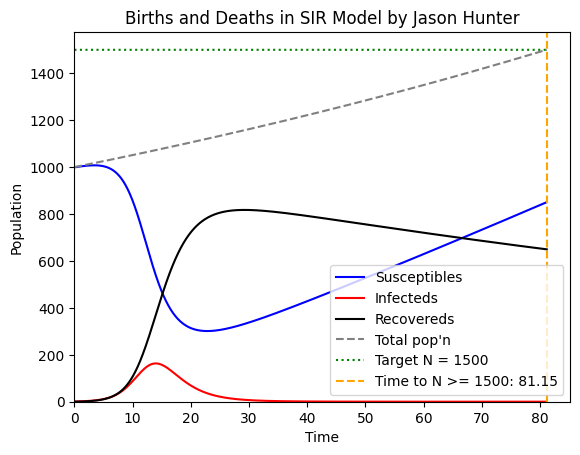

In [3]:
# Parameters:
S0 = 999
I0 = 1
R0 = 0
beta = 1
gamma = 0.5
mu_birth = 0.01
mu_death = 0.5 * mu_birth  # = 0.005
t_max = 85
stepsize = 0.05
n_target = 1500  # Stop sim if pop'n exceeds this

S,I,R,T = SIR(S0,I0,R0,
              beta, gamma,
              mu_birth, mu_death,
              t_max, stepsize, n_target)

fig, ax = plt.subplots()
ax.plot(T,S, color='b', label='Susceptibles')
ax.plot(T,I, color='r', label='Infecteds')
ax.plot(T,R, color='k', label='Recovereds')

N = S + I + R
ax.plot(T,N, color='gray', linestyle='--', label='Total pop\'n')

n_target = np.full(len(T), n_target)
ax.plot(T,n_target, color='green', linestyle=':', label='Target pop\'n')

time_to_target = T[np.where(N >= n_target)[0][0]] if np.any(N >= n_target) else None
if time_to_target is not None:
    ax.axvline(x=time_to_target, color='orange', linestyle='--')

ax.set_xlabel('Time')
ax.set_ylabel('Population')
ax.legend(['Susceptibles', 'Infecteds', 'Recovereds', 'Total pop\'n', 'Target N = 1500', 'Time to N >= 1500: {}'.format(time_to_target)])
ax.set_title('Births and Deaths in SIR Model by Jason Hunter')
ax.set_ylim(bottom=0)
ax.set_xlim(left=0)

/var/folders/8_/cxjvz9c51291hfp8mwjm_wmh0000gn/T/ipykernel_31264/3468320573.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  solution = float(fsolve(h_x, guess, xtol=1e-12, maxfev=2000))


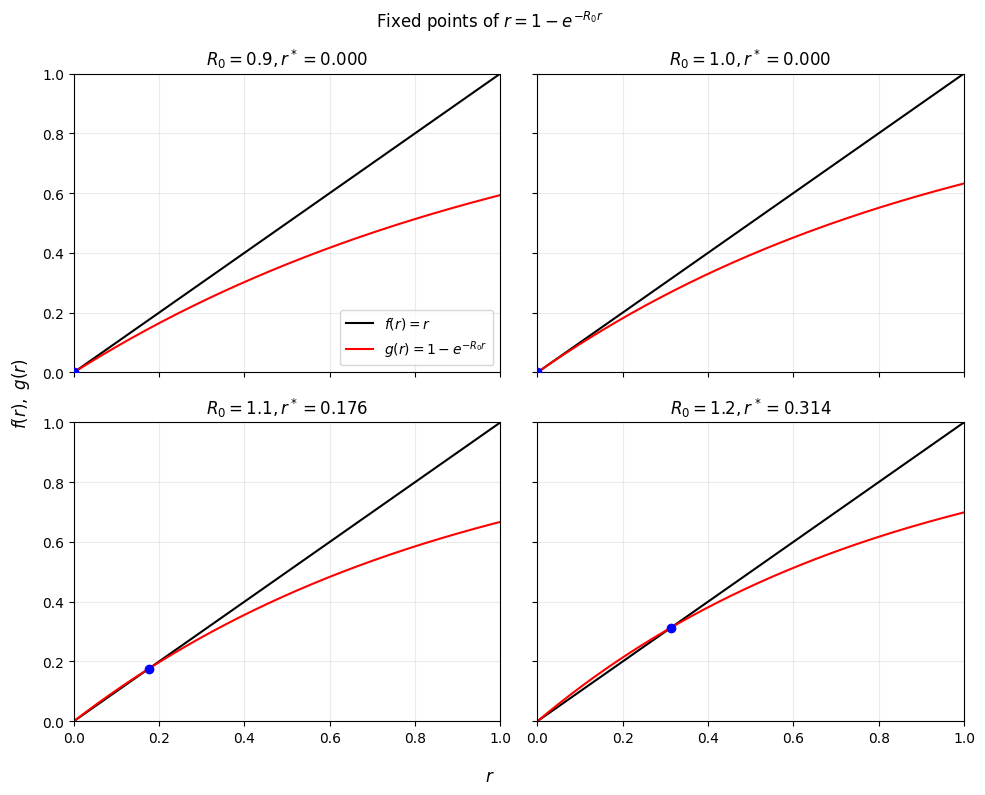

In [11]:
from scipy.optimize import fsolve

def h_x_factory(R0):
    """Returns a function h(x) = x - (1 - exp(-R0 * x))
    such that the root of h(x) gives the final size of an epidemic
    in a standard SIR model without births and deaths.

    Args:
        R0 (float): The basic reproduction number.

    Returns:
        function: A function that computes h(x).
    """
    return lambda x: x - (1 - np.exp(-R0 * x))

def find_root(R0):
    """Finds the root of h(x) = x - (1 - exp(-R0 * x)) using fsolve.

    Args:
        R0 (float): The basic reproduction number.

    Returns:
        float: The final size of the epidemic.
    """
    if R0 <= 1:
        return 0.0  # No epidemic occurs if R0 <= 1
    h_x = h_x_factory(R0)
    for guess in (0.6, 0.8, 0.95):
        solution = float(fsolve(h_x, guess, xtol=1e-12, maxfev=2000))
        if 1e-10 < solution < 1 + 1e-10 and abs(h_x(solution)) < 1e-8:
            return max(0.0, min(1.0, solution))
    # If no suitable root found, return the root from the first guess
    return 0.0

R0_list = [0.9,1.0,1.1,1.2]
r = np.linspace(0,1,1000)

fig, axs = plt.subplots(2, 2, figsize=(10,8), sharex=True, sharey=True)
for ax, R0 in zip(axs.flatten(), R0_list):
    f_vals = r
    g_vals = 1 - np.exp(-R0 * r)
    ax.plot(r, f_vals, label=r'$f(r) = r$', color = 'k')
    ax.plot(r, g_vals, label=r'$g(r) = 1 - e^{-R_0 r}$', color = 'r')
    r_star = find_root(R0)
    ax.scatter([r_star], [r_star], color='blue', zorder=5)
    ax.set_title(fr'$R_0 = {R0}, r^* = {r_star:.3f}$')
    
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.grid(True, alpha = 0.25)
    
axs.flat[0].legend(loc='lower right')
fig.suptitle(r'Fixed points of $r = 1 - e^{-R_0 r}$')
fig.supxlabel(r'$r$')
fig.supylabel(r'$f(r),\ g(r)$')
plt.tight_layout()
plt.show()